## Import library

In [25]:
import os
from openpose import OpenposeDetector
from PIL import Image
from utils import HWC3, resize_image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import openai
import torch

# Set your OpenAI API key
openai.api_key = 'YOUR_OPENAI_API_KEY'  # Replace with your actual API key

image_resolution = 512 # output resolution for human pose image
detect_resolution = 512 # input resolution for human pose detection
apply_openpose = OpenposeDetector()

## Function to define motion part for segmentation

In [26]:
def define_motion_part(image):
    img_width, img_height = image.size
    print(f"Image width: {img_width}, height: {img_height}")
    x = 0
    w = img_width
    while True:
        print("Please define the motion part rectangle.")
        try:
            # x = int(input("Enter x (left coordinate): "))
            y = int(input("Enter y (top coordinate): "))
            # w = int(input("Enter width of motion part: "))
            h = int(input("Enter height of motion part: "))
        except ValueError:
            print("Invalid input. Please enter integers.")
            continue

        # Preview the selection
        fig, ax = plt.subplots(1)
        ax.imshow(image)
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()

        confirm = input("Is this selection correct? Type 'ok' to confirm or 'retry' to re-enter: ")
        if confirm.lower() == 'ok':
            break
    rows = int(input("How many rows does it have?"))
    return x, y, w, h, rows

## Function to define frame dimensions and segment frames

In [32]:
def segment_frames(motion_part, num_rows):
    w, h = motion_part.size
    y_offset = 0
    row_heights = []
    rows = []
    default_height = h // num_rows

    print(f"Total image height: {h}")
    top_height = 0
    bottom_height = default_height
    
    for row in range(num_rows):
        if row == 2:
            break
        top_offset = 0
        bottom_offset = 0
        while bottom_height<= h:
            img_copy = motion_part.copy()
            row_image = motion_part.crop((0, top_height + top_offset, w, bottom_height+bottom_offset))
            fig, ax = plt.subplots(1)
            ax.imshow(row_image)
            plt.title(f"Preview of Row {row + 1}")
            plt.show()
            confirm = input("Is this row height correct? Type 'ok' to confirm or 'retry' to re-enter: ")
            if confirm.lower() == 'ok':
                rows.append(row_image)
                top_height += default_height
                bottom_height += default_height
                break
            else:
                try:
                    top_offset = int(input(f"Enter the offset for top coordinate (+/-)"))
                    bottom_offset = int(input(f"Enter the offset for bottom coordinate (+/-)"))
                    temp_top = top_offset + top_height
                    temp_bottom = bottom_height+bottom_offset
                    if temp_top  <= 0 or temp_bottom > h:
                        print(f"Invalid height. Your height: ({temp_top},{temp_bottom}). Must be between 1 and {h}.")
                        top_offset = 0
                        bottom_offset = 0
                        continue
                except ValueError:
                    print("Invalid input. Please enter integers.")
                    continue
    return rows

## Function to save the main image

In [28]:
def save_main_image(frames, character_dir):
    main_frame = frames[0][0]
    main_frame_path = os.path.join(character_dir, 'main.png')
    main_frame.save(main_frame_path)
    print(f"Main image saved at {main_frame_path}")
    return main_frame_path

## Function to define motions and save frames

In [51]:
def define_and_save_motions(character_dir, rows=None):
    cache_dir = os.path.join(character_dir, 'cache')
    main_frame_path = os.path.join(character_dir, 'main.png')
    os.makedirs(cache_dir, exist_ok=True)

    # Check for cached rows
    cached_rows = sorted([os.path.join(cache_dir,d) for d in os.listdir(cache_dir) if d.startswith('row_')])
    if cached_rows:
        print("Found cached rows. Resuming from cache...")
    else:
        for row_num, image in enumerate(rows):
            row_cache_dir = os.path.join(cache_dir, f'row_{row_num}.png')
            # os.makedirs(row_cache_dir, exist_ok=True)
            image.save(row_cache_dir)
            # for idx, frame in enumerate(frames[row_num]):
            #     frame_path = os.path.join(row_cache_dir, f'frame_{idx}.png')
            #     frame.save(frame_path)
        cached_rows = sorted([os.path.join(cache_dir,d) for d in os.listdir(cache_dir) if d.startswith('row_')])

    for image_path in cached_rows:
        row_cache_jpg = Image.open(image_path)
        w, h = row_cache_jpg.size
        row_num = int(image_path.split(".")[0].split("_")[-1])
        
        if not os.path.exists(main_frame_path):
            while True:
                img_copy = row_cache_jpg.copy()
                fig, ax = plt.subplots(1)
                x_ticks = np.arange(0, img_copy.size[0], 50)
                ax.imshow(img_copy)
                plt.title(f"Preview of Row {row_num + 1}")
                ax.set_xticks(x_ticks)
                plt.xticks(fontsize=8)
                plt.show()
                try:
                    print(f"Crop the main image file for this character")
                    left_cord = int(input("Enter left coordinate: "))
                    right_cord = int(input("Enter right coordinate: "))
                    # Validate indices
                    if left_cord <= 0 or right_cord > w:
                        print(f"Indices out of range for row {row_num}. Please enter indices between 0 and {len(frames_in_row)-1}.")
                        continue
                except ValueError:
                    print("Invalid input. Please enter integers.")
                    continue
                    
                fig, ax = plt.subplots(1)
                row_image = img_copy.crop((left_cord,0, right_cord, h))
                ax.imshow(row_image)
                plt.show()
                confirm = input("Is this segmentation correct? Type 'ok' to confirm or 'retry' to re-enter: ")
                if confirm.lower() == 'ok':
                    row_image.save(main_frame_path)
                    break
                else:
                    continue
        
        while True:
            img_copy = row_cache_jpg.copy()
            fig, ax = plt.subplots(1)
            x_ticks = np.arange(0, img_copy.size[0], 50)
            ax.imshow(img_copy)
            plt.title(f"Preview of Row {row_num + 1}")
            ax.set_xticks(x_ticks)
            plt.xticks(fontsize=8)
            plt.show()
            motion_name = input(f"Enter motion name for frames in row {row_num} (or 'skip' to skip this row, or 'done' if finished with this row): ")
            if motion_name.lower() == 'skip':
                print(f"Skipping row {row_num}.")
                break
            elif motion_name.lower() == 'done':
                print(f"Finished defining motions for row {row_num}.")
                break
            else:
                motion_dir = os.path.join(character_dir, motion_name)
                os.makedirs(motion_dir, exist_ok=True)
                
                try:
                    left_cord = int(input("Enter left coordinate: "))
                    right_cord = int(input("Enter right coordinate: "))
                    # Validate indices
                    if left_cord <= 0 or right_cord > w:
                        print(f"Indices out of range for row {row_num}. Please enter indices between 1 and {w}.")
                        continue
                except ValueError:
                    print("Invalid input. Please enter integers.")
                    continue
                
                fig, ax = plt.subplots(1)
                row_image = img_copy.crop((left_cord,0, right_cord, h))
                ax.imshow(row_image)
                plt.show()

                confirm = input("Is this segmentation correct? Type 'ok' to confirm or 'retry' to re-enter: ")
                if confirm.lower() == 'ok':
                    np_row_image = np.asarray(row_image)
                    detected_map_1 = apply_openpose(resize_image(np_row_image, detect_resolution),
                                 include_body=True,
                                 include_hand=True,
                                 include_face=True,
                                 use_dw_pose=False)
                    detected_map_2 = apply_openpose(resize_image(np_row_image, detect_resolution),
                                 include_body=True,
                                 include_hand=True,
                                 include_face=True,
                                 use_dw_pose=True)
                    pose_image1 = Image.fromarray(detected_map_1) 
                    pose_image2 = Image.fromarray(detected_map_2) 
                    
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))                
                    # Display pose_image1 on the first subplot
                    ax1.imshow(pose_image1)
                    ax1.set_title('Pose Image 1')
                    ax1.axis('off')
                
                    # Display pose_image2 on the second subplot
                    ax2.imshow(pose_image2)
                    ax2.set_title('Pose Image 2')
                    ax2.axis('off')
                
                    # Show the figure
                    plt.show()
                    try:
                        choice = int(input("Which pose image do you prefer? Type '1' for Pose Image 1 or '2' for Pose Image 2 or other keys to drop it"))
                        frame_path = os.path.join(motion_dir, f'frame.png')
                        pose_path = os.path.join(motion_dir, f'human_pose.png')
                        if choice == 1:
                            row_image.save(frame_path)
                            pose_image1.save(pose_path)
                        elif choice == 2:
                            frame_path = os.path.join(motion_dir, f'frame.png')
                            row_image.save(frame_path)
                            pose_image2.save(pose_path)
                        else:
                            os.rmdir(motion_dir)
                    except ValueError:
                        os.rmdir(motion_dir)
                        continue
                else:
                    print("restart")
                    continue

                # Save the frames for this motion
                # motion_dir = os.path.join(character_dir, motion_name)
                # os.makedirs(motion_dir, exist_ok=True)
                # for i in range(start_index, end_index + 1):
                #     frame = frames_in_row[i]
                #     frame_number = i - start_index + 1
                #     frame_path = os.path.join(motion_dir, f'frame{frame_number}.png')
                #     frame.save(frame_path)
                # print(f"Motion '{motion_name}' frames saved in {motion_dir}")
                # Continue to allow defining more motions in this row

        # After processing the row, delete the cache for that row
        # for fname in os.listdir(row_cache_dir):
        #     os.remove(os.path.join(row_cache_dir, fname))
        # os.rmdir(row_cache_dir)
        os.remove(image_path)
        print(f"Cache for row {row_num} cleared.")

    # After all rows are processed, remove the cache directory if empty
    if not os.listdir(cache_dir):
        os.rmdir(cache_dir)

## Function to generate character description using GPT

In [14]:
def generate_character_description(main_frame_path, character_dir):
    print("Generating character description using GPT...")
    # Prepare the prompt (assuming the image cannot be directly sent)
    prompt = "Describe the appearance of a character based on the following description:"

    # Since we cannot send the image directly, you might need to extract features manually or describe the image in text.
    # For demonstration purposes, we'll use a placeholder description.
    placeholder_description = "A brave warrior with a shining armor and a sword."

    full_prompt = f"{prompt}\n\n{placeholder_description}"

    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=full_prompt,
        max_tokens=150
    )
    description = response.choices[0].text.strip()
    # Save the description
    prompt_path = os.path.join(character_dir, 'prompt.txt')
    with open(prompt_path, 'w') as f:
        f.write(description)
    print(f"Character description saved at {prompt_path}")


## Iterate the image directory

Bandit has already been fully processed. Skipping.
Firen has already been fully processed. Skipping.
Found cached rows. Resuming from cache...


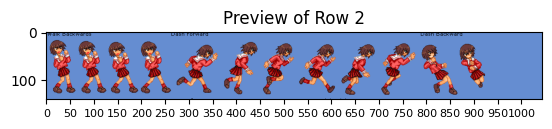

Enter motion name for frames in row 1 (or 'skip' to skip this row, or 'done' if finished with this row):  walk backward
Enter left coordinate:  1
Enter right coordinate:  270


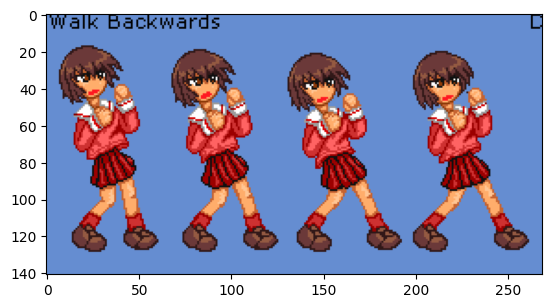

Is this segmentation correct? Type 'ok' to confirm or 'retry' to re-enter:  ok


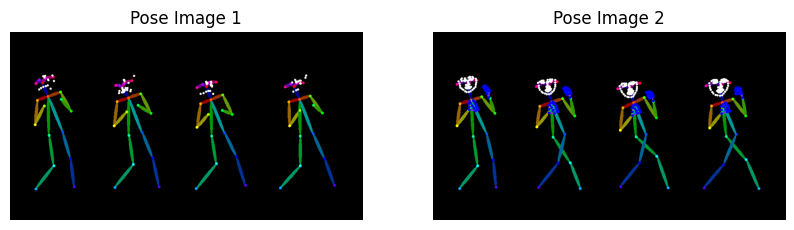

Which pose image do you prefer? Type '1' for Pose Image 1 or '2' for Pose Image 2 or other keys to drop it 1


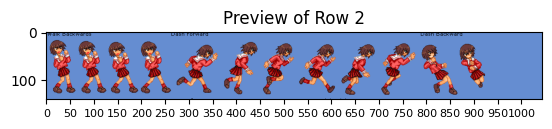

Enter motion name for frames in row 1 (or 'skip' to skip this row, or 'done' if finished with this row):  dash forward
Enter left coordinate:  270
Enter right coordinate:  780


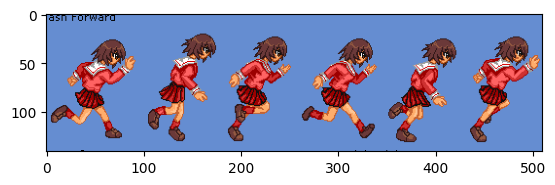

Is this segmentation correct? Type 'ok' to confirm or 'retry' to re-enter:  ok


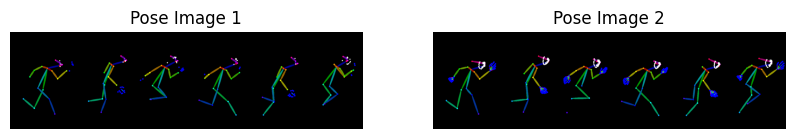

Which pose image do you prefer? Type '1' for Pose Image 1 or '2' for Pose Image 2 or other keys to drop it 2


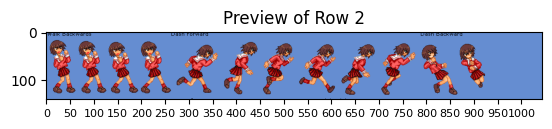

Enter motion name for frames in row 1 (or 'skip' to skip this row, or 'done' if finished with this row):  dash backward
Enter left coordinate:  780
Enter right coordinate:  940


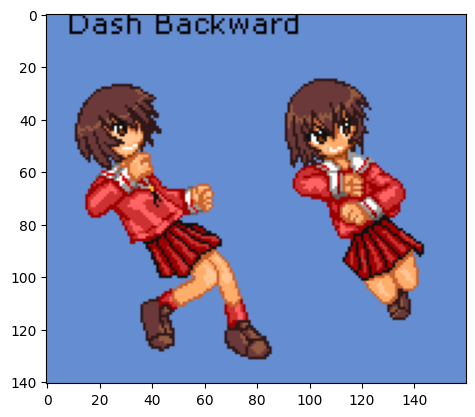

Is this segmentation correct? Type 'ok' to confirm or 'retry' to re-enter:  ok


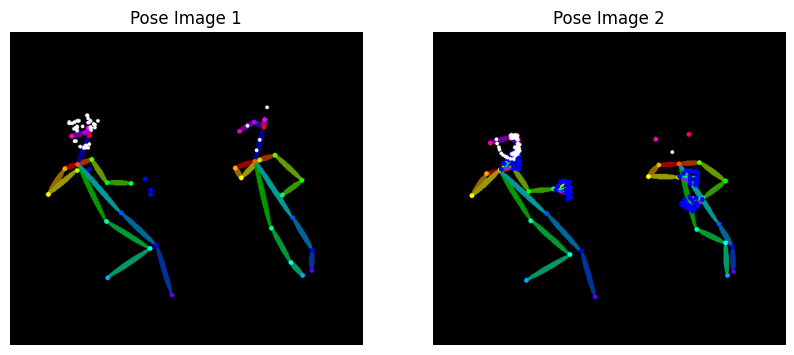

In [ ]:
def process_character_sheet(image_path, character_name):
    character_dir = os.path.join(motion_frames_dir, character_name)
    cache_dir = os.path.join(character_dir, 'cache')
    frames = None
    rows = None

    if not os.path.exists(character_dir):
        os.mkdir(character_dir)
    # Check if the character has already been processed completely
    elif os.path.exists(os.path.join(character_dir, 'main.png')) and not os.path.exists(cache_dir):
        print(f"{character_name} has already been fully processed. Skipping.")
        return

    # Check if cache exists
    if not os.path.exists(cache_dir):
        # Open the image
        image = Image.open(image_path)
        print(f"Processing {character_name}...")

        # Step 2: Define motion part for segmentation
        x, y, w, h, rows = define_motion_part(image)

        # Crop the image to motion part
        motion_part = image.crop((x, y, x + w, y + h))

        # Step 3: Define frame width and height and segment frames
        rows = segment_frames(motion_part, rows)

        # Step 3: Save the first frame as main.png
        # main_frame_path = save_main_image(frames, character_dir)
    # Step 4: Define motions and save frames with caching
    define_and_save_motions(character_dir,rows)

    # Step 6: Generate character description using GPT
    # if not os.path.exists(os.path.join(character_dir, 'prompt.txt')):
    #     generate_character_description(main_frame_path, character_dir)
        
# Set up directories
spritesheet_dir = 'spritesheet'
motion_frames_dir = 'motion_frames'

# Ensure motion_frames directory exists
if not os.path.exists(motion_frames_dir):
    os.makedirs(motion_frames_dir)

# Iterate over the character sheet images
for filename in os.listdir(spritesheet_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        character_name = os.path.splitext(filename)[0]
        image_path = os.path.join(spritesheet_dir, filename)
        process_character_sheet(image_path, character_name)